In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math
import time

实现步骤：
1.对多曝光图像序列{xk}进行双线性下采样，获得降采样的图像序列{Xkl}以减少数据的运算量
2.CAN网络以降采样的图像序列为输入，输出低分辨率的权重图 。
3.然后，以{Xkl}为引导图，对权重图{Wkl}进行引导滤波
4.联合双线性插值上采样，获得全分辨率（与Xk分辨率相同）的权重图{Wk}
5.最后融合图像Y根据多曝光图像序列的加权求和获得
6.评价机制

所以神经网络训练的作用主要是获得权重图，是对权重函数和加权融合函数的修改更新，本质上和debevec算法是一样的。

需要学习的是：
1.怎么进行双线性下采样
2.CAN网络结构和神经网络训练相关（工作量最大）
3.怎么进行引导滤波
4.学习双线性插值上采样
5.加权融合算法：Hadamard乘积
6.评价机制

CAN网络结构相关：
1.采用空洞卷积方式，在不牺牲图像空间分辨率的情况下，获得更大的感受野。
2.卷积层：卷积核大小为3*3，卷积核数目为24
3.线性整流激活函数（LRelu）
4.自适应归一化操作->避免梯度消失；加快学习收敛速度
5.最后一层卷积作用于生成和输入图像大小一致的权重图，卷积核大小为1*1，且不使用自适应归一化操作
6.此外{Xkl}以权重共享的方式输入CAN网络->保证了本网络可以融合任意数量的不同曝光度图像

需要学习的是：
1.CAN网络实现
2.空洞卷积（需要学习，也可以考虑换成标准卷积）
3.自适应归一化操作
4.权重共享方式
5.损失函数设计（比较难，如果这个很难，不是很会实现的话，可以考虑换成其他的损失函数，例如常用的最小二乘损失之类的，就是效果会略差，假装是咱们的创新点，也不用考虑参数τc的问题了）
6.自学习（用预训练好的模型参数进行参数微调，减弱或消除光晕现象）

自学习过程（可能要学一下非监督学习的相关知识，但是代码应该和训练代码差不多）：
1.基于前面提到的网络结构和损失，采用多曝光图像(多于两幅)对网络进行训练，获得最佳的权重参数
2.面向两幅极度曝光图像的融合，将学习到的最佳权重参数作为网络权重的初始值，不改变网络的结构和损失函数，基于当前两幅极度曝光的测试图像，对网络进行再学习和优化，非监督地自学习得到适用于当前融合图像的最佳参数。

数据集：https://github.com/hangxiaotian/Perceptual-Multi-exposure-Image-Fusion

自学习应该还蛮必要的，不然会出现过曝现象
然后最后还可以加以分析，就像论文最后那部分参数τc对极度曝光情况的影响
作者也提出了优化的方向，就是怎么获得最优的参数τc

难点：
1.学习自适应归一化（论文）
2.写损失函数
3.引导滤波（论文）
4.加权融合（灰度和彩色）
5.评价机制（待定）

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd ./drive/MyDrive/FLNotebooks
!ls

/content/drive/MyDrive/FLNotebooks
1.ipynb  dataset  final_lab.ipynb


In [ ]:
import re
def sort_key(s):
    #获取图片名称
    tail = s.split('\\')[-1]
    # 匹配开头数字序号
    c = re.findall('\d+', tail)[0]
    return int(c)

def strsort(alist):
    alist.sort(key=sort_key)
    return alist

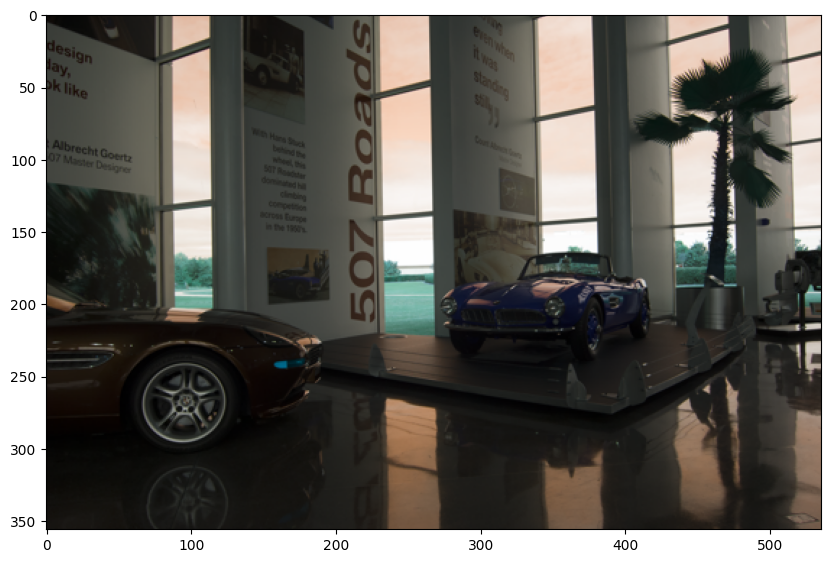

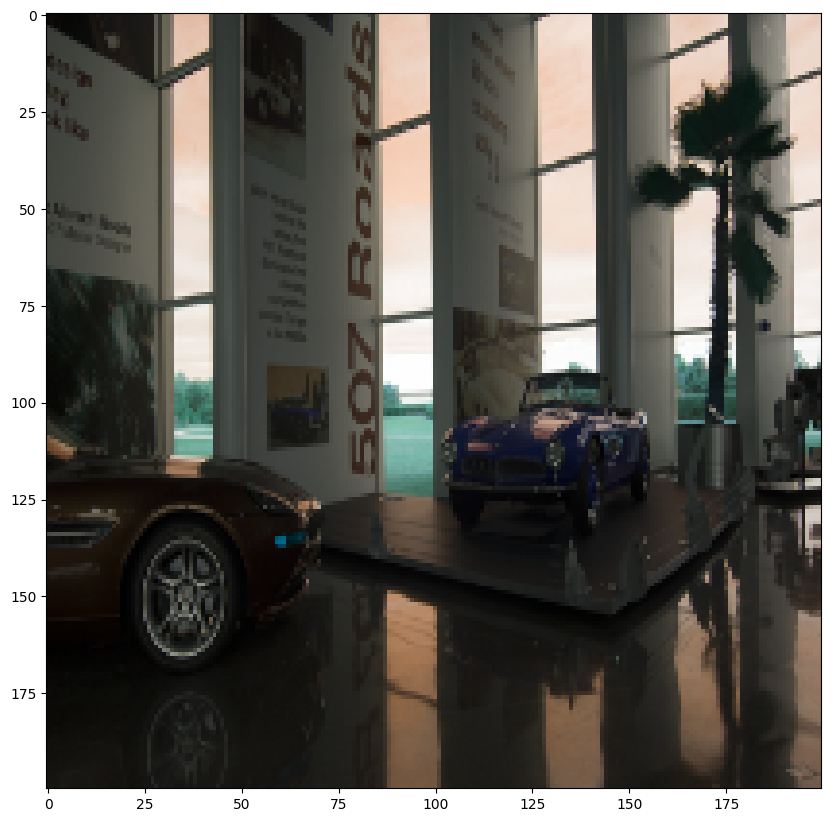

In [ ]:
# 对多曝光图像序列{xk}进行双线性下采样，获得降采样的图像序列{Xkl}以减少数据的运算量
import numpy as np #导入numpy模块
from PIL import Image #入PIL模块用于读取图片，也可使用opencv
import os
import torch.nn.functional as F
import torch
import cv2
import pylab
import matplotlib.pyplot as plt

images=[]
path = './dataset/Dataset/dataset1/HDRPS_downsampling_8/'	#数据集路径,这个数据集中每个组有9张照片
#循环遍历数据集下的所有子文件(如果连子目录也读取)
domList = os.listdir(path)
domList = sorted(domList)
#domList.sort(key=lambda x: int(x.replace("_MDF","").split('.')[0]))#按照数字进行排序后按顺序读取文件夹下的图片
for name_file in domList:
    #遍历子文件下的所有图片文件
    imgList = os.listdir(path+name_file)
    imgList=sorted(imgList)#按照数字进行排序后按顺序读取文件夹下的图片,9个一组
    for img_file in imgList:
      # print(img_file)	#打印当前读取的图片名
      #以下代码根据需要更改
      img = cv2.imread(path+name_file+'/'+img_file)
      if img.shape[0] > img.shape[1]:
          img = np.transpose(img, (1, 0, 2))
      images.append(img)
#images = np.array(images)	#转为float64类型的Numpy数组
#imgs = strsort(images)
# plt.subplot(1, 2, 1)

plt.figure(figsize=(10, 20))
plt.imshow(images[4])

downsampled_images = []

# 下采样比例 (例如，宽高各减半)
scale = 0.5

for image in images:
  new_width = int(image.shape[1] * scale)
  new_height = int(image.shape[0] * scale)
  # 使用双线性插值进行下采样
  downsampled_image = cv2.resize(image, (200, 200), interpolation=cv2.INTER_LINEAR)
  # 将下采样后的图像添加到列表中
  downsampled_images.append(downsampled_image)

# 因为Conv2d默认的图片形式是NCHW的，所以我改掉了
n = len(downsampled_images)
h, w, c = downsampled_images[0].shape
image_array = np.zeros((n, c, h, w), dtype=np.uint8)
for i, image in enumerate(downsampled_images):
  # # if image.shape[0] > image.shape[1]:
  # #    image_array[i] = np.transpose(image, (2, 1, 0)) # 若为竖直图，转换为水平图
  # else:
    image_array[i] = np.transpose(image, (2, 0, 1))

plt.figure(figsize=(10, 20))
plt.imshow(np.transpose(image_array[4], (1, 2, 0)))
# print(image_array[4].shape)


m = len(images)
h, w, c = images[0].shape
image_array_0 = np.zeros((m, c, h, w), dtype=np.uint8)
for i, image in enumerate(images):
  if image.shape[0] > image.shape[1]:
     image_array_0[i] = np.transpose(image, (2, 1, 0))
  else:
    # print(image.shape)
    image_array_0[i] = np.transpose(image, (2, 0, 1))


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
# 定义神经网络
class CANNet(nn.Module):
    def __init__(self):
        super(CANNet,self).__init__()
        #定义六层卷积层
        self.conv = nn.Sequential(
            # 空洞卷积
            # pytorch封装卷积层
            # 第一层 (W-3)/1+1 （H-3)/1+1
            nn.Conv2d(in_channels = 3,out_channels = 24,kernel_size = 3 , stride = 1,padding=1,dilation=1),
            nn.BatchNorm2d(24),
            # inplace-选择是否进行覆盖运算
            nn.LeakyReLU(negative_slope=0.01),
            # 第二层
            nn.Conv2d(in_channels = 24,out_channels = 24,kernel_size = 3 , stride = 1,padding=2,dilation=2),
            nn.BatchNorm2d(24),
            # inplace-选择是否进行覆盖运算
            nn.LeakyReLU(negative_slope=0.01),
            # 第三层
            nn.Conv2d(in_channels = 24,out_channels = 24,kernel_size = 3 , stride = 1,padding=2,dilation=2),
            nn.BatchNorm2d(24),
            # inplace-选择是否进行覆盖运算
            nn.LeakyReLU(negative_slope=0.01),
            # 第四层
            nn.Conv2d(in_channels = 24,out_channels = 24,kernel_size = 3 , stride = 1,padding=2,dilation=2),
            nn.BatchNorm2d(24),
            # inplace-选择是否进行覆盖运算
            nn.LeakyReLU(negative_slope=0.01),
            # 第五层
            nn.Conv2d(in_channels = 24,out_channels = 24,kernel_size = 3 , stride = 1,padding=2,dilation=2),
            nn.BatchNorm2d(24),
            # inplace-选择是否进行覆盖运算
            nn.LeakyReLU(negative_slope=0.01),
            # 第六层
            nn.Conv2d(in_channels = 24,out_channels = 24,kernel_size = 3 , stride = 1,padding=2,dilation=2),
            nn.BatchNorm2d(24),
            # inplace-选择是否进行覆盖运算
            nn.LeakyReLU(negative_slope=0.01),
            # 第七层
            nn.Conv2d(in_channels = 24,out_channels = 3,kernel_size = 1 , stride = 1,padding=0,dilation=1)
        )

    def forward(self,x):
        out = self.conv(x)
        return out
    # 可能要学一下，式子有点多，今天先不写了
    # 定义损失函数和优化器(一个例子)
    # criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=0.01)
    def backward(self):
      loss = getLoss(output, target_tensor) #还需要写一下loss函数
      loss.backward()  # 计算反向传播,我看网上有说BatchNorm2d和Lrelu的反向传播在 PyTorch 中是自动处理的，所以应该这样就行

In [ ]:
import torch

def _diff_x(src, r):
    cum_src = src.cumsum(-2)

    left = cum_src[..., r:2*r + 1, :]
    middle = cum_src[..., 2*r + 1:, :] - cum_src[..., :-2*r - 1, :]
    right = cum_src[..., -1:, :] - cum_src[..., -2*r - 1:-r - 1, :]

    output = torch.cat([left, middle, right], -2)

    return output

def _diff_y(src, r):
    cum_src = src.cumsum(-1)

    left = cum_src[..., r:2*r + 1]
    middle = cum_src[..., 2*r + 1:] - cum_src[..., :-2*r - 1]
    right = cum_src[..., -1:] - cum_src[..., -2*r - 1:-r - 1]

    output = torch.cat([left, middle, right], -1)

    return output

def boxfilter2d(src, radius):
    return _diff_y(_diff_x(src, radius), radius)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GuidedFilter2d(nn.Module):
    def __init__(self, radius: int, eps: float):
        super().__init__()
        self.r = radius
        self.eps = eps

    def forward(self, x, guide):
        if guide.shape[1] == 3:
            return guidedfilter2d_color(guide, x, self.r, self.eps)
        elif guide.shape[1] == 1:
            return guidedfilter2d_gray(guide, x, self.r, self.eps)
        else:
            raise NotImplementedError

class FastGuidedFilter2d(GuidedFilter2d):
    """Fast guided filter"""
    def __init__(self, radius: int, eps: float, s: int):
        super().__init__(radius, eps)
        self.s = s

    def forward(self, x, guide):
        # print(guide.shape[1])
        if guide.shape[1] == 3:
            return guidedfilter2d_color(guide, x, self.r, self.eps, self.s)
        elif guide.shape[1] == 1:
            return guidedfilter2d_gray(guide, x, self.r, self.eps, self.s)
        else:
            raise NotImplementedError

def guidedfilter2d_color(guide, src, radius, eps, scale=None):
    """guided filter for a color guide image

    Parameters
    -----
    guide: (B, 3, H, W)-dim torch.Tensor
        guide image
    src: (B, C, H, W)-dim torch.Tensor
        filtering image
    radius: int
        filter radius
    eps: float
        regularization coefficient
    """
    assert guide.shape[1] == 3
    if src.ndim == 3:
        src = src[:, None]
    if scale is not None:
        guide_sub = guide.clone()
        src = F.interpolate(src, scale_factor=1./scale, mode="nearest")
        guide = F.interpolate(guide, scale_factor=1./scale, mode="nearest")
        radius = radius // scale

    guide_r, guide_g, guide_b = torch.chunk(guide, 3, 1) # b x 1 x H x W
    ones = torch.ones_like(guide_r)
    N = boxfilter2d(ones, radius)

    mean_I = boxfilter2d(guide, radius) / N # b x 3 x H x W
    mean_I_r, mean_I_g, mean_I_b = torch.chunk(mean_I, 3, 1) # b x 1 x H x W

    mean_p = boxfilter2d(src, radius) / N # b x C x H x W

    mean_Ip_r = boxfilter2d(guide_r * src, radius) / N # b x C x H x W
    mean_Ip_g = boxfilter2d(guide_g * src, radius) / N # b x C x H x W
    mean_Ip_b = boxfilter2d(guide_b * src, radius) / N # b x C x H x W

    cov_Ip_r = mean_Ip_r - mean_I_r * mean_p # b x C x H x W
    cov_Ip_g = mean_Ip_g - mean_I_g * mean_p # b x C x H x W
    cov_Ip_b = mean_Ip_b - mean_I_b * mean_p # b x C x H x W

    var_I_rr = boxfilter2d(guide_r * guide_r, radius) / N - mean_I_r * mean_I_r + eps # b x 1 x H x W
    var_I_rg = boxfilter2d(guide_r * guide_g, radius) / N - mean_I_r * mean_I_g # b x 1 x H x W
    var_I_rb = boxfilter2d(guide_r * guide_b, radius) / N - mean_I_r * mean_I_b # b x 1 x H x W
    var_I_gg = boxfilter2d(guide_g * guide_g, radius) / N - mean_I_g * mean_I_g + eps # b x 1 x H x W
    var_I_gb = boxfilter2d(guide_g * guide_b, radius) / N - mean_I_g * mean_I_b # b x 1 x H x W
    var_I_bb = boxfilter2d(guide_b * guide_b, radius) / N - mean_I_b * mean_I_b + eps # b x 1 x H x W

    # determinant
    cov_det = var_I_rr * var_I_gg * var_I_bb \
        + var_I_rg * var_I_gb * var_I_rb \
            + var_I_rb * var_I_rg * var_I_gb \
                - var_I_rb * var_I_gg * var_I_rb \
                    - var_I_rg * var_I_rg * var_I_bb \
                        - var_I_rr * var_I_gb * var_I_gb # b x 1 x H x W

    # inverse
    inv_var_I_rr = (var_I_gg * var_I_bb - var_I_gb * var_I_gb) / cov_det # b x 1 x H x W
    inv_var_I_rg = - (var_I_rg * var_I_bb - var_I_rb * var_I_gb) / cov_det # b x 1 x H x W
    inv_var_I_rb = (var_I_rg * var_I_gb - var_I_rb * var_I_gg) / cov_det # b x 1 x H x W
    inv_var_I_gg = (var_I_rr * var_I_bb - var_I_rb * var_I_rb) / cov_det # b x 1 x H x W
    inv_var_I_gb = - (var_I_rr * var_I_gb - var_I_rb * var_I_rg) / cov_det # b x 1 x H x W
    inv_var_I_bb = (var_I_rr * var_I_gg - var_I_rg * var_I_rg) / cov_det # b x 1 x H x W

    inv_sigma = torch.stack([
        torch.stack([inv_var_I_rr, inv_var_I_rg, inv_var_I_rb], 1),
        torch.stack([inv_var_I_rg, inv_var_I_gg, inv_var_I_gb], 1),
        torch.stack([inv_var_I_rb, inv_var_I_gb, inv_var_I_bb], 1)
    ], 1).squeeze(-3) # b x 3 x 3 x H x W

    cov_Ip = torch.stack([cov_Ip_r, cov_Ip_g, cov_Ip_b], 1) # b x 3 x C x H x W

    a = torch.einsum("bichw,bijhw->bjchw", (cov_Ip, inv_sigma))
    b = mean_p - a[:, 0] * mean_I_r - a[:, 1] * mean_I_g - a[:, 2] * mean_I_b # b x C x H x W

    mean_a = torch.stack([boxfilter2d(a[:, i], radius) / N for i in range(3)], 1)
    mean_b = boxfilter2d(b, radius) / N

    if scale is not None:
        guide = guide_sub
        mean_a = torch.stack([F.interpolate(mean_a[:, i], guide.shape[-2:], mode='bilinear') for i in range(3)], 1)
        mean_b = F.interpolate(mean_b, guide.shape[-2:], mode='bilinear')

    q = torch.einsum("bichw,bihw->bchw", (mean_a, guide)) + mean_b

    return q

def guidedfilter2d_gray(guide, src, radius, eps, scale=None):
    """guided filter for a gray scale guide image

    Parameters
    -----
    guide: (B, 1, H, W)-dim torch.Tensor
        guide image
    src: (B, C, H, W)-dim torch.Tensor
        filtering image
    radius: int
        filter radius
    eps: float
        regularization coefficient
    """
    if guide.ndim == 3:
        guide = guide[:, None]
    if src.ndim == 3:
        src = src[:, None]

    if scale is not None:
        guide_sub = guide.clone()
        src = F.interpolate(src, scale_factor=1./scale, mode="nearest")
        guide = F.interpolate(guide, scale_factor=1./scale, mode="nearest")
        radius = radius // scale

    ones = torch.ones_like(guide)
    N = boxfilter2d(ones, radius)

    mean_I = boxfilter2d(guide, radius) / N
    mean_p = boxfilter2d(src, radius) / N
    mean_Ip = boxfilter2d(guide*src, radius) / N
    cov_Ip = mean_Ip - mean_I * mean_p

    mean_II = boxfilter2d(guide*guide, radius) / N
    var_I = mean_II - mean_I * mean_I

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = boxfilter2d(a, radius) / N
    mean_b = boxfilter2d(b, radius) / N

    if scale is not None:
        guide = guide_sub
        mean_a = F.interpolate(mean_a, guide.shape[-2:], mode='bilinear')
        mean_b = F.interpolate(mean_b, guide.shape[-2:], mode='bilinear')

    q = mean_a * guide + mean_b
    return q

In [ ]:
#其中himages存放原始输入（高分辨率引导图像）
def train_model(model, dataloader, criterion, optimizer, num_epochs, himages):
    for epoch in range(num_epochs):
        running_loss = 0.0  # 用于记录每个 epoch 的损失
        input_x=[]
        output_w=[]
        y = []
        for i, inputs in enumerate(dataloader):
            if i%9==8 :
              for j in range(8):
                #进行加权融合
                print("w:",output_w[j].shape)
                print("x",input_x[j].shape)
                y += output_w[j] * input_x[j]
              input_x=[]
              output_w=[]
              print("Outputs shape:", outputs.shape)
              print("High resolution outputs shape:", outputs_high_res.shape)
              loss = criterion(y) ##待修改的损失函数
              # 反向传播
              optimizer.zero_grad()  # 清除之前的梯度
              loss.backward()  # 计算梯度
              optimizer.step()  # 更新权重
              # 累计损失
              running_loss += loss.item()
            # 将数据和目标移动到 GPU 上（如果可用）
            # inputs = inputs.to(device)
            input_x.append(inputs.unsqueeze(0))
            # 正向传播
            outputs = model(inputs.unsqueeze(0))
            # outputs = outputs.squeeze(0)
            # outputs_merged = outputs.view(3, 8, outputs.shape[1], outputs.shape[2]).mean(1)  # 形状变为 (3, H, W)
            # print(outputs_merged.shape)
            GF = FastGuidedFilter2d(30, 1e-4, 2)

            outputs_high_res = GF(outputs, outputs)
            # print(outputs_high_res.shape)
            output_hr_np = outputs_high_res.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
            # 可视化结果
            # plt.imshow(output_hr_np)
            # plt.show()

            output_w.append(outputs_high_res)

        # 输出每个 epoch 的平均损失
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(dataloader)}")

    input_x=[]
    output_w=[]
    # 输出最终的处理结果（这里可以根据需求进行修改，比如保存结果到文件）
    for i, inputs in enumerate(dataloader):
      #每9张图像为一组
      if i%9==8 :
        for i in 9:
          #进行加权融合,y就是最终的结果
          y += output_w[i] * input_x[i]
          # 保存或打印 y
          # 例如，保存结果到文件
          output_image = y.cpu().detach().numpy()
          output_image_path = f"output_image_{i/9}.png"
        input_x=[]
        output_w=[]
      # 将数据和目标移动到 GPU 上（如果可用）
      # inputs = inputs.to("GPU")
      input_x.append(inputs)
      # 正向传播
      outputs = model(inputs.unsqueeze(0))
      GF = FastGuidedFilter2d(30, 1e-4, 2)
      outputs_high_res = GF(outputs, outputs)
      # print(outputs_high_res.shape)
      output_hr_np = outputs_high_res.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
      output_w.append(outputs_high_res)
    print("Training complete!")

In [ ]:
# 输入数据
# input_data = torch.from_numpy(image_array.transpose(0, 3, 1, 2)).float()

# 创建神经网络模型
model = CANNet()

criterion = nn.CrossEntropyLoss()  # 交叉熵损失,这个损失函数好像要自己打一下
optimizer = optim.SGD(model.parameters(), lr=0.01)  # SGD 优化器

image_array = torch.tensor(image_array, dtype=torch.float32)
image_array_0 = torch.tensor(image_array_0, dtype=torch.float32)

# print(image_array_0.shape)

train_model(model=model, dataloader=image_array, criterion=criterion, optimizer=optimizer, num_epochs=1, himages=image_array_0)

# 进行前向传播
# output = model.forward(input_data)
# print("Output shape after forward pass:", output.shape)

# # 损失函数和梯度
# loss = np.random.rand(*output.shape)  # 假设这是损失函数的梯度
# print("Loss shape:", loss.shape)

# # 进行反向传播
# gradient = model.backward(loss)
# print("Gradient shape after backward pass:", gradient.shape)

<ipython-input-27-ae155786f978>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_array = torch.tensor(image_array, dtype=torch.float32)
<ipython-input-27-ae155786f978>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_array_0 = torch.tensor(image_array_0, dtype=torch.float32)


w: torch.Size([1, 3, 200, 200])
x torch.Size([1, 3, 200, 200])
w: torch.Size([1, 3, 200, 200])
x torch.Size([1, 3, 200, 200])
w: torch.Size([1, 3, 200, 200])
x torch.Size([1, 3, 200, 200])
w: torch.Size([1, 3, 200, 200])
x torch.Size([1, 3, 200, 200])
w: torch.Size([1, 3, 200, 200])
x torch.Size([1, 3, 200, 200])
w: torch.Size([1, 3, 200, 200])
x torch.Size([1, 3, 200, 200])
w: torch.Size([1, 3, 200, 200])
x torch.Size([1, 3, 200, 200])
w: torch.Size([1, 3, 200, 200])
x torch.Size([1, 3, 200, 200])
Outputs shape: torch.Size([1, 3, 200, 200])
High resolution outputs shape: torch.Size([1, 3, 200, 200])


TypeError: CrossEntropyLoss.forward() missing 1 required positional argument: 'target'